In [4]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [5]:
# defining the device to run the model on GPU 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
data_dir_Train = "/kaggle/input/digit-recognizer/train.csv"

In [6]:
def ACC_Plot(epochs, acc):
    """
    epochs: list contains the number of epochs
    acc: Accuracy of each epoch
    """
    plt.xlabel('Epochs') 
    plt.ylabel('accuracy')
    plt.plot(epochs, acc)

In [7]:
def plot_classification(model, data_loader, class_names):
    """
    *Plot the classification results of a PyTorch model*
    model: A trained PyTorch model.
    data_loader: A PyTorch DataLoader that contains the input images.
    class_names: A list of class names corresponding to the output classes of the model.
    """

    # Setting the model to evaluation mode
    model.eval()

    # Create empty lists to store the true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the input data and generate predictions
    with torch.no_grad():
        for images, labels in data_loader:
            # Forward pass through the model
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Convert the outputs to class predictions
            _, predicted = torch.max(outputs, 1)

            # Append the true and predicted labels to the lists
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Normalize the confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Generate the classification report
    cr = classification_report(true_labels, predicted_labels, target_names=class_names)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           xlabel='Predicted label',
           ylabel='True label',
           title='Confusion matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_norm[i, j] > thresh else "black")
    fig.tight_layout()

    # Print the classification report
    print(cr)


In [8]:
def train(network, train_loader, optimizer, loss_function):
    # creating list to hold loss and accuracy per batch
    loss_per_batch = []
    acc_per_batch = []

    # iterating through batches
    print('training...')
    for images, labels in tqdm(train_loader):
        # sending images to device
        images, labels = images.to(device), labels.to(device)

        # zeroing optimizer gradients
        optimizer.zero_grad()

        # classifying instances
        classifications = network(images)

        # computing loss/how wrong our classifications are
        loss = loss_function(classifications, labels)
        loss_per_batch.append(loss.item())

        # computing gradients/the direction that fits our objective
        loss.backward()

        # optimizing weights/slightly adjusting parameters
        optimizer.step()

        # computing accuracy for the batch
        preds = torch.argmax(classifications, dim=1)
        acc = (preds == labels).sum().item() / len(labels)
        acc_per_batch.append(acc)

    # computing the overall accuracy for the training set
    train_acc = sum(acc_per_batch) / len(acc_per_batch)
#   returning the acc_per_batch to use it in the acc_per_batch plot
    return acc_per_batch, train_acc

In [9]:
# Define the nn architecture
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [10]:
# Reading the training CSV file
TRAIN_df= pd.read_csv(data_dir_Train)

In [11]:
# splitting the training file into Train, Validation
train_df, val_df = train_test_split(TRAIN_df, test_size=0.2, shuffle= False)
# splitting the X, Y
train_df_Y = train_df["label"]
train_df_X = train_df.drop(columns = "label")
# splitting the X, Y
val_df_Y = val_df["label"]
val_df_X = val_df.drop(columns = "label")

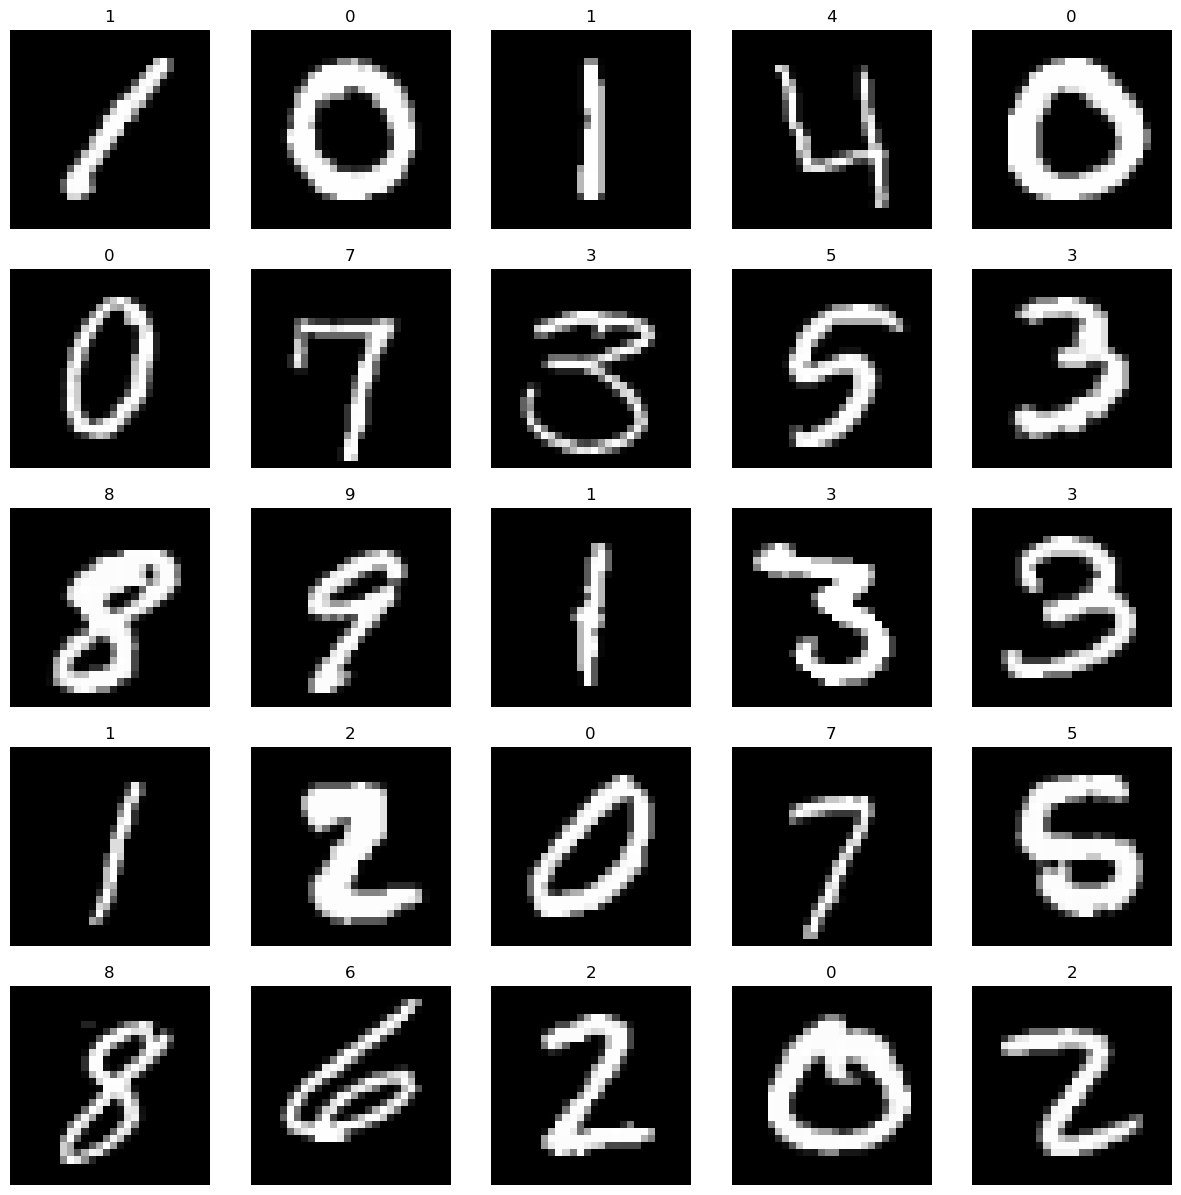

In [12]:
# plotting number of pics to see the labels with images
fig,ax = plt.subplots(5,5,figsize = (15,15))
ax = ax.ravel()
for i in range(25):
    image = train_df_X.iloc[i]
    ax[i].imshow(image.to_numpy().reshape(28,28),cmap = 'gray')
    ax[i].set_title(train_df_Y[i])
    ax[i].axis("off")
  
plt.show()

In [13]:
# coverting the dataframe to numpy array and reshaping it
train_mnist_X = train_df_X.to_numpy().reshape(-1,1, 28, 28)
# normalizing the pixels
train_mnist_X = np.divide(train_mnist_X, 255)
# converting the numpy array to tensor
train_mnist_X = torch.tensor(train_mnist_X, dtype=torch.float32)
# converting the Y Df to numpy array then to tensor
train_mnist_Y = torch.tensor(np.array(train_df_Y), dtype=torch.long)
# ------------------------------
# coverting the dataframe to numpy array and reshaping it
test_mnist_X = val_df_X.to_numpy().reshape(-1,1, 28, 28)
# normalizing the pixels
test_mnist_X = np.divide(test_mnist_X, 255)
# converting the numpy array to tensor
test_mnist_X = torch.tensor(test_mnist_X, dtype=torch.float32)
# converting the Y Df to numpy array then to tensor
test_mnist_Y = torch.tensor(np.array(val_df_Y), dtype=torch.long)

In [14]:
# showing the shape of X tensor 
test_mnist_X.shape

torch.Size([8400, 1, 28, 28])

In [15]:
# making a DataSets for train, test
train_dataset = TensorDataset(train_mnist_X, train_mnist_Y)
val_dataset = TensorDataset(test_mnist_X, test_mnist_Y)

In [16]:
# making 2 Dataloaders fo the train, validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
# showing the shape of the single batch in the train loader
image, label= next(iter(train_loader))
image.shape

torch.Size([32, 1, 28, 28])

In [18]:
# Defining the model, loss function and optimizer
model = Classifier()
model = model.cuda() if device else model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [19]:
# Training the model
num_epochs = 5
Acc = []
for epoch in range(num_epochs):
    Train_acc_per_batch, acc = train(model, train_loader, optimizer, criterion)
    Acc.append(acc)
    print("Epoch accuracy: ",acc)
print("Train accuracy:",acc)
print("All Done!")

training...


  0%|          | 0/1050 [00:00<?, ?it/s]

Epoch accuracy:  0.8206547619047619
training...


  0%|          | 0/1050 [00:00<?, ?it/s]

Epoch accuracy:  0.9708630952380952
training...


  0%|          | 0/1050 [00:00<?, ?it/s]

Epoch accuracy:  0.9786904761904762
training...


  0%|          | 0/1050 [00:00<?, ?it/s]

Epoch accuracy:  0.9830059523809523
training...


  0%|          | 0/1050 [00:00<?, ?it/s]

Epoch accuracy:  0.9838392857142857
Train accuracy: 0.9838392857142857
All Done!


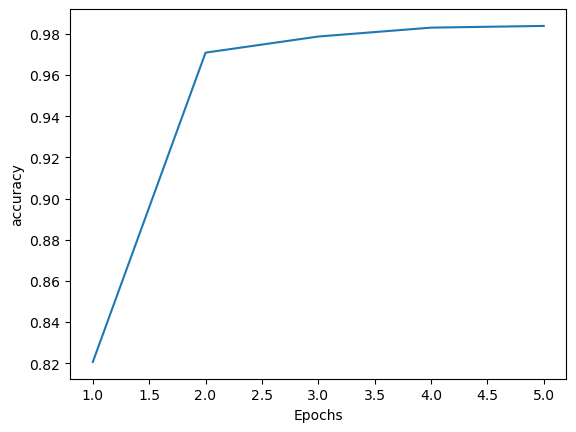

In [20]:
# accuracy per batch graph
ACC_Plot([1,2,3,4,5],Acc)

In [24]:
# Evaluating the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Validation accuracy: {correct/total:.4f}")

Validation accuracy: 0.9830


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       852
           1       0.98      0.99      0.99       950
           2       0.97      0.98      0.97       801
           3       0.97      0.99      0.98       882
           4       0.99      0.98      0.98       811
           5       0.99      0.99      0.99       747
           6       1.00      0.98      0.99       831
           7       0.98      0.99      0.98       884
           8       0.98      0.99      0.98       802
           9       0.99      0.94      0.97       840

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



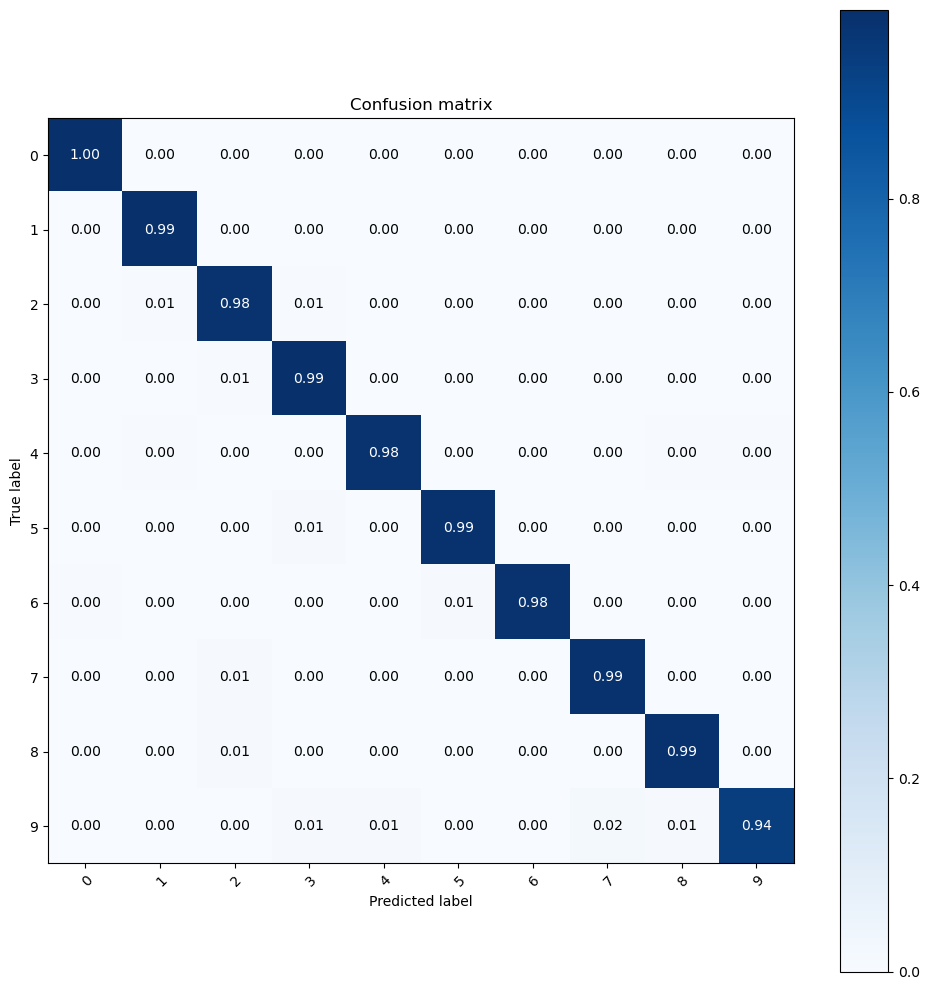

In [22]:
# ploting the confusion matrix 
labels = np.arange(10)
labels=labels.astype(str)
plot_classification(model, test_loader,labels)

In [23]:
# saving the model
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/kaggle/working/state.pth")